<a href="https://colab.research.google.com/github/ankitmehani/RAG_Based_LLM-DE_Individual_Project/blob/main/Harry_Potter_RAG_LLM_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSIN0166: Data Engineering
________________________
# Individual Coursework:
________________________

## PotterPal
PotterPal, your wizarding buddy, is an AI chatbot created with Langchain technology. It excels in answering questions about the Harry Potter series, employing dynamic RAG pipelines, diverse language models, FAISS for speedy text retrieval, and Gradio for an interactive chat interface.


### Word Count - 4000 Max (Excluding table of contents and appendix)

  
________________________



#### Link for GitHub Repository:
https://github.com/ankitmehani/RAG_Based_LLM-DE_Individual_Project


# Table of Contents:
_________________________________
* [1. Overview](#Bullet1)
* [2. Models](#Bullet2)
* [3. Installs](#Bullet3)  
* [4. Imports](#Bullet4)  
* [5. CFG](#Bullet5)  
* [6. Define Model](#Bullet6)  
* [7. Pipeline](#Bullet7)  
* [8. Langchain](#Bullet8)
* [9. Splitter](#Bullet9)
* [10. Create Embeddings](#Bullet10)
* [11. Load vector database](#Bullet11)
* [12. Prompt Template](#Bullet12)
* [13. Retriever Chain](#Bullet13)
* [14. Post-process outputs](#Bullet14)
* [15. Ask questions](#Bullet15)
* [16. Gradio Chat UI](#Bullet16)
* [17. Conclusions](#Bullet17)
* [18. Appendix and logs](#Bullet18)

# Overview

- Use Langchain to build a chatbot that can answer questions about Harry Potter books
- Flexible and customizable RAG pipeline (Retrieval Augmented Generation)
- Experiment with various LLMs (Large Language Models)
- Use FAISS vector store to store text embeddings created with Sentence Transformers from 🤗. FAISS runs on GPU and it is much faster than Chroma
- Use Retrieval chain to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Leverage Colab GPU ( T4) with Hugging Face Accelerate
- Chat UI with Gradio


###  Models
- TheBloke/wizardLM-7B-HF
- daryl149/llama-2-7b-chat-hf
- daryl149/llama-2-13b-chat-hf
- mistralai/Mistral-7B-Instruct-v0.2

Below code will allows us to access files stored in your Google Drive directly from a Colab notebook, facilitating seamless integration of data stored in Google Drive with Colab workflow

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RAG_Architecture

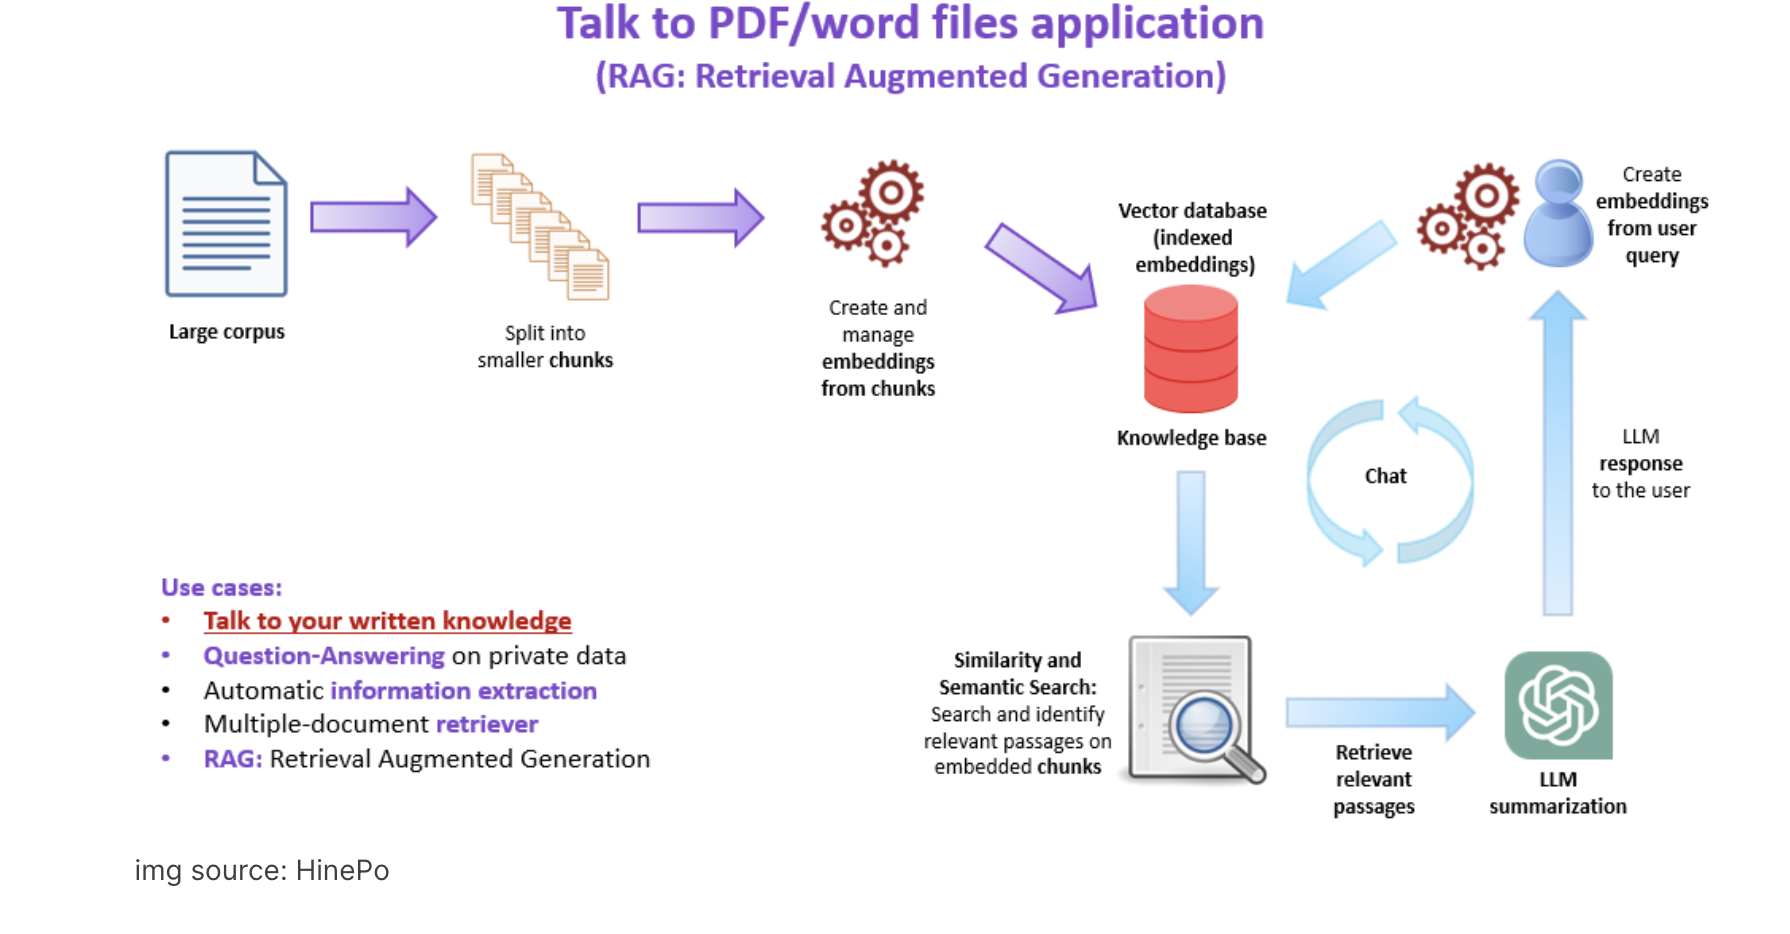

In [34]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/RAG_Architecture.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


### Installs

In [21]:
# Path to your Google Drive
import os
google_drive_path = '/content/drive/MyDrive/DE_Individual_Project/'



files = os.listdir(google_drive_path)


# Print the list of files and directories
print("Files and directories in your Google Drive:")
for file in files:
    print(file)

Files and directories in your Google Drive:
RAG_Architecture.png
harry-potter-vectordb
input
Output


Upload aws_config.ini containing AWS credentials, file is being kept in local drive for security purposes

In [25]:
import os
from google.colab import files

# Check if the file already exists
if 'aws_config.ini' in os.listdir('.'):
    print('aws_config.ini already exists in the current directory. No need to upload.')
else:
    # Upload the aws_config.ini file into Google Drive
    uploaded = files.upload()

    # Check if the file was uploaded successfully
    if 'aws_config.ini' in uploaded:
        print('aws_config.ini uploaded successfully!')
    else:
        print('Upload failed. Please make sure the file is selected and try again.')


aws_config.ini already exists in the current directory. No need to upload.


Retrive AWS Credentials and set environment variables.

In [26]:
# Import necessary libraries
import configparser
import os

# Initialize the configuration parser
config = configparser.ConfigParser()

# Specify the path to your configuration file
config_file_path = 'aws_config.ini'  # Make sure the file is uploaded to Colab

# Read the configuration file
config.read(config_file_path)

# Access AWS credentials
aws_region = config.get('aws', 'region')
aws_access_key_id = config.get('aws', 'access_key_id')
aws_secret_access_key = config.get('aws', 'secret_access_key')

# Set environment variables
os.environ["AWS_DEFAULT_REGION"] = aws_region
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key



Install necessary packages

In [27]:
%%time

from IPython.display import clear_output

! pip install sentence_transformers==2.2.2

! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding

! pip install -qq -U transformers
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes
! pip install configparser
! pip install boto3


clear_output()

CPU times: user 2.82 s, sys: 368 ms, total: 3.18 s
Wall time: 4min 32s


### Imports

In [28]:
%%time

import warnings
warnings.filterwarnings("ignore")

import boto3
import glob
import textwrap
import time

import langchain

### loaders
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

### splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

### prompts
from langchain import PromptTemplate, LLMChain

### vector stores
from langchain.vectorstores import FAISS

### models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

clear_output()

CPU times: user 10.6 s, sys: 1.56 s, total: 12.1 s
Wall time: 21.8 s


In [29]:
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.1.16
torch: 2.2.1+cu121
transformers: 4.39.3


Below code will download all books from s3 bucket - hpbooks into colab library - /content/drive/MyDrive/DE_Individual_Project/books/ (If directory is not created will create new directory)

In [30]:
# Initialize S3 client
s3_client = boto3.client(
    service_name='s3',
    region_name=aws_region,
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

# Specify the bucket name
bucket_name = 'hpbooks'

# Directory to save downloaded books
download_dir = '/content/drive/MyDrive/DE_Individual_Project/books/'

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)

# List objects in the bucket
objects = s3_client.list_objects_v2(Bucket=bucket_name)

# Check if the bucket contains any objects
if 'Contents' in objects:
    # Retrieve keys (file paths) of the objects
    keys = [obj['Key'] for obj in objects['Contents']]

    # Download each book from S3 bucket
    for key in keys:
        # Define local file path for the downloaded book
        local_file_path = os.path.join(download_dir, os.path.basename(key))

        # Download the book from S3 bucket
        s3_client.download_file(bucket_name, key, local_file_path)

        print(f"Downloaded {key} to {local_file_path}")
else:
    print("No objects found in the bucket.")


Downloaded HP1 - Harry Potter and the Sorcerer_s Stone.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP1 - Harry Potter and the Sorcerer_s Stone.pdf
Downloaded HP2 - Harry Potter and the Chamber of Secrets.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP2 - Harry Potter and the Chamber of Secrets.pdf
Downloaded HP3 - Harry Potter and the Prisoner of Azkaban.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf
Downloaded HP4 - Harry Potter and the Goblet of Fire.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP4 - Harry Potter and the Goblet of Fire.pdf
Downloaded HP5 - Harry Potter and the Order of the Phoenix.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf
Downloaded HP6 - Harry Potter and the Half-Blood Prince.pdf to /content/drive/MyDrive/DE_Individual_Project/books/HP6 - Harry Potter and the Half-Blood Prince.pdf
Downloaded HP7 - H

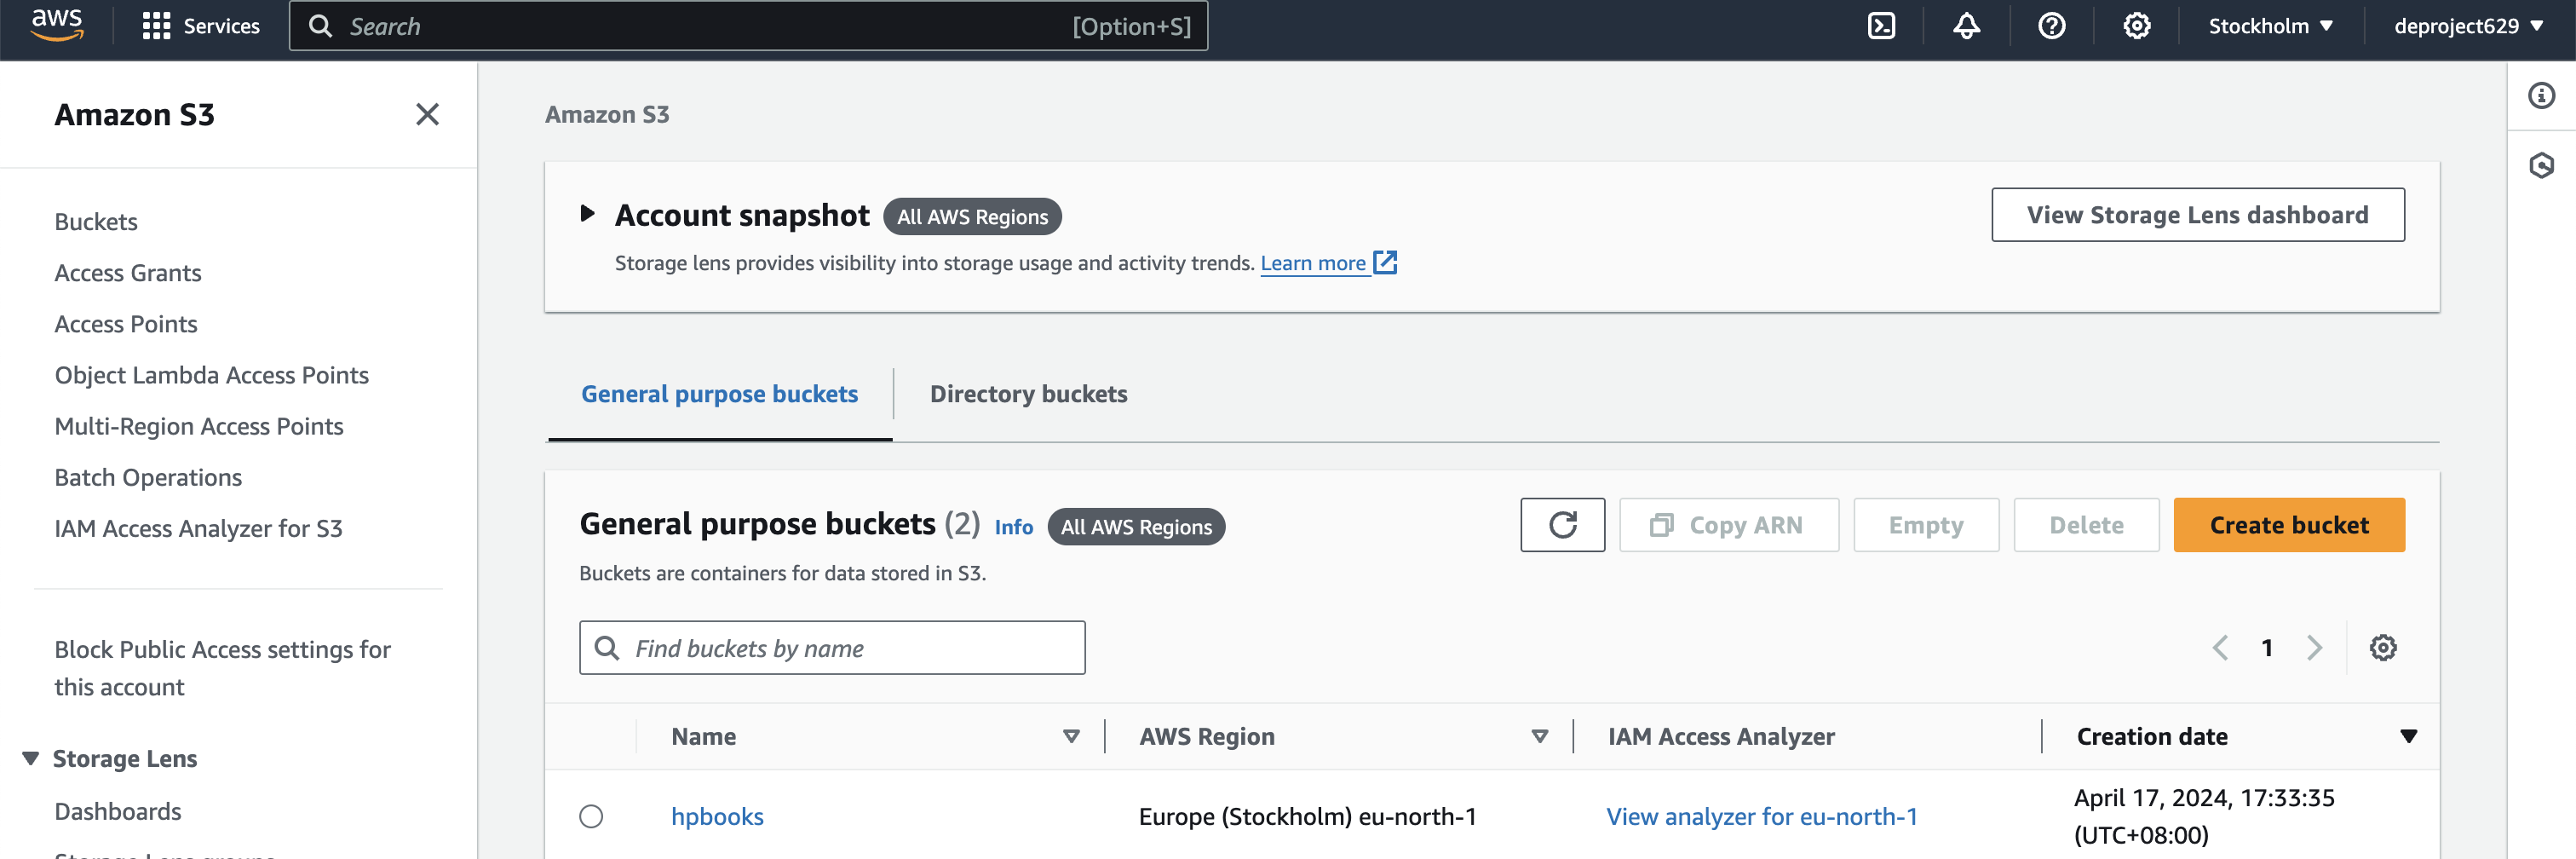

In [32]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/input/AWS_hpbooks.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


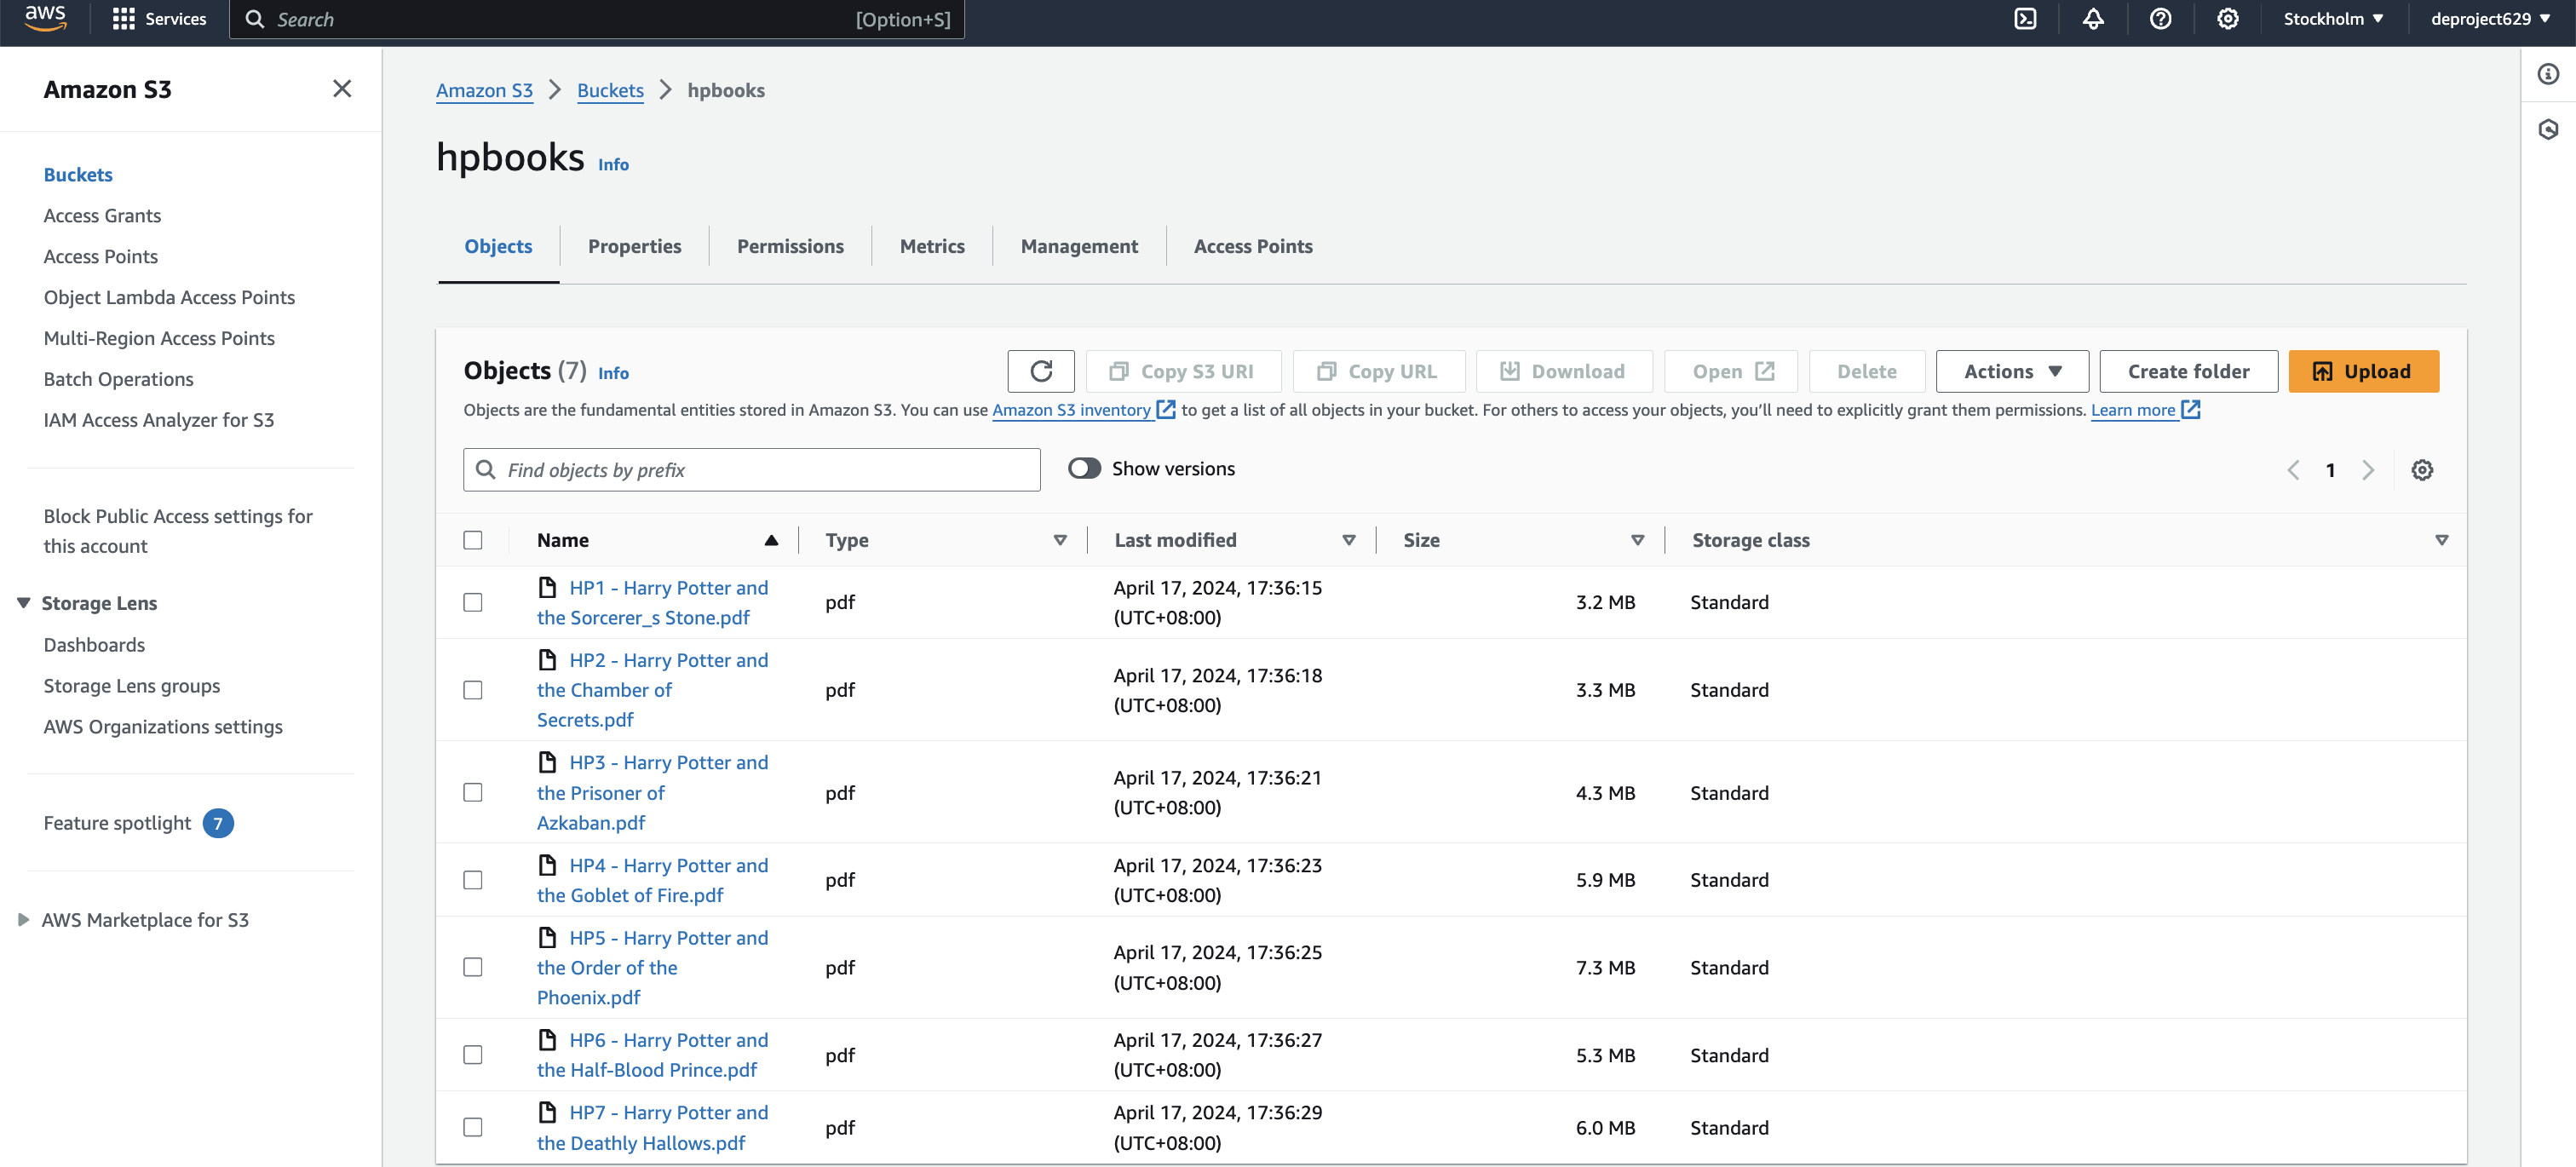

In [33]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/input/AWS_hpbooks_contents.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


In [31]:
import glob
sorted(glob.glob('/content/drive/MyDrive/DE_Individual_Project/books/*'))

['/content/drive/MyDrive/DE_Individual_Project/books/HP1 - Harry Potter and the Sorcerer_s Stone.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP2 - Harry Potter and the Chamber of Secrets.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP4 - Harry Potter and the Goblet of Fire.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP5 - Harry Potter and the Order of the Phoenix.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP6 - Harry Potter and the Half-Blood Prince.pdf',
 '/content/drive/MyDrive/DE_Individual_Project/books/HP7 - Harry Potter and the Deathly Hallows.pdf']

### CFG
- CFG class enables easy and organized experimentation

 The CFG class encapsulates various configuration parameters essential for configuring and fine-tuning the behavior of the chatbot or text processing system, including LLM settings, text splitting parameters, embeddings model, and file paths for input and output storage.





In [ ]:
class CFG:
    # LLMs
    model_name = 'llama2-13b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15

    # splitting
    split_chunk_size = 800
    split_overlap = 0

    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 6

    # paths
    PDFs_path = '/content/drive/MyDrive/DE_Individual_Project/books/'
    Embeddings_path =  '/content/drive/MyDrive/DE_Individual_Project/input/faiss-hp-sentence-transformers'
    Output_folder = '/content/drive/MyDrive/DE_Individual_Project/harry-potter-vectordb'

### Define model

In [ ]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )

        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )

        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [ ]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

ImportError: Using `bitsandbytes` 8-bit quantization requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes: `pip install -i https://pypi.org/simple/ bitsandbytes`

In [ ]:
model.eval()

NameError: name 'model' is not defined

### 🤗 Pipeline
- Hugging Face Pipeline

In [ ]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

In [ ]:
llm

In [ ]:
%%time
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm.invoke(query)

### 🦜🔗 Langchain
- Multiple document retriever with LangChain

In [ ]:
CFG.model_name

### Loader
- Directory loader for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
   - load de PDF files split into chunks
   - create embeddings
   - save the embeddings in a vector store
   - After that you can just load the saved embeddings to do -- similarity search with the user query, and then use the LLM to answer the question

In [ ]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

In [ ]:
print(f'We have {len(documents)} books in total')

In [ ]:
documents[0]



### Splitter
- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- RecursiveCharacterTextSplitter

### Create Embeddings

- Embed and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://langchain.readthedocs.io/en/latest/vector_stores.html)
- [FAISS - langchain](https://github.com/facebookresearch/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/abs/1908.10084)
- This is a nice 4 minutes [video about vector stores](https://www.youtube.com/watch?v=ue_KewpQVHg)


- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min


We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search.

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from here.


In [ ]:
# Ensure documents is a list
documents = list(documents)

# Split the documents into chunks
texts = []
for document_list in documents:
    # Split each document in the list using the text splitter
    split_texts = text_splitter.split_documents([document_list])  # Pass each document as a list
    # Extend the list of texts with the split texts
    texts.extend(split_texts)

print(f'We have created {len(texts)} chunks from {len(documents)} books')


### Load vector database
 - After saving the vector database, we need to load from google drive or database we will be saving input embedding path.

- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [ ]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts,
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") # save in output folder
    vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") # save in input folder

In [ ]:
import os
from langchain_community.vectorstores.faiss import FAISS

embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

# Set the flag to allow dangerous deserialization
allow_dangerous_deserialization = True

# Load local vector database with dangerous deserialization enabled
vectordb = FAISS.load_local(
    CFG.Embeddings_path + '/faiss_index_hp',
    embeddings,  # Assuming `embeddings` is an Embeddings object
    allow_dangerous_deserialization=allow_dangerous_deserialization
)




In [ ]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

### Prompt Template
- Custom prompt

In [ ]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

### Retriever chain
- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)


In [ ]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever,
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [ ]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

In [ ]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

### Post-process outputs
- Format llm response
- Cite sources (PDFs)
- Change width parameter to format the output

In [ ]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])

    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )

    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [ ]:
def llm_ans(query):
    start = time.time()

    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)

    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

### Ask questions
- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [ ]:
CFG.model_name

In [ ]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

In [ ]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))

In [ ]:
query = "What are horcrux?"
print(llm_ans(query))

In [ ]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

### Gradio Chat UI

- Create a chat UI with Gradio
- ChatInterface docs
- The notebook should be running if you want to use the chat interface

In [ ]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! pip install --upgrade gradio -qq
clear_output()

In [ ]:
import gradio as gr
print(gr.__version__)

In [ ]:
def predict(message, history):
  output = message # debug mode

  output = str(llm_ans(message)).replace("\n", "<br/>")
  return output


demo = gr.ChatInterface(
      predict,
      title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering'
       )


demo.queue()
demo.launch()

In [ ]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/Output/Chatbot_Q1.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


In [ ]:
from IPython.display import display

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/Output/Chatbot_Q2.png'

# Open the image file
image = Image.open(image_path)


# Display the image using IPython display
display(image)


### Conclusions



PotterPal, your wizarding buddy, stands as a testament to the transformative capabilities of advanced Natural Language Processing (NLP) techniques in the realm of conversational AI. Built using Langchain technology, PotterPal excels in providing insightful responses to inquiries related to the enchanting world of Harry Potter. Employing dynamic RAG pipelines, diverse language models, FAISS for speedy text retrieval, and Gradio for an interactive chat interface, PotterPal delivers a seamless and engaging user experience. Leveraging Colab's GPU infrastructure, particularly the T4 GPU, alongside Hugging Face Accelerate, has empowered PotterPal with efficient model training and inference capabilities. Through PotterPal, users can embark on an immersive journey through the magical universe of Harry Potter, gaining valuable insights and experiencing the magic of intelligent conversational agents.

### Appendix


1. https://medium.com/@dialoglk/building-a-chatbot-using-your-documents-with-langchain-2c90b9b0c6c7
2. https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2
3. https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
4. https://python.langchain.com/docs/modules/data_connection/
5. https://medium.com/@baptisteloquette.entr/langchain-arxiv-tutor-long-text-summarization-retrievalqa-and-vector-databases-6d5cb1dc7e14
6. https://discuss.huggingface.co/t/how-to-use-specified-gpus-with-accelerator-to-train-the-model/10967
7. https://www.gradio.app/guides/creating-a-chatbot-fast
8. https://huggingface.co/TheBloke/wizardLM-7B-HF
9. https://huggingface.co/daryl149/llama-2-7b-chat-hf
10. https://huggingface.co/daryl149/llama-2-13b-chat-hf
11. https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

